## Entrainement de nos modèles sur la base RAVDESS

In [1]:
!pip3 install pymrmr
!pip3 install audiomentations
!pip3 install pydub
!python3 -V

Defaulting to user installation because normal site-packages is not writeable
  Using cached pymrmr-0.1.11.tar.gz (69 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      running bdist_wheel
      running build
      running build_py
      package init file 'pymrmr/__init__.py' not found (or not a regular file)
      running egg_info
      writing pymrmr.egg-info/PKG-INFO
      writing dependency_links to pymrmr.egg-info/dependency_links.txt
      writing requirements to pymrmr.egg-info/requires.txt
      writing top-level names to pymrmr.egg-info/top_level.txt
      reading manifest file 'pymrmr.egg-info/SOURCES.txt'
      reading manifest template 'MANIFEST.in'
      adding license file 'LICENSE'
      adding license file 'AUTHORS.rst'
      writing manifest file 'pymrmr.egg-info/SOURCES.txt'
      creating build
      creating build/lib.macosx-

In [1]:
import os
import re
import joblib
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from audiomentations import Compose, TimeStretch, PitchShift, AddGaussianNoise
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# from pydub import AudioSegment
# from pydub.effects import normalize
# from sklearn.preprocessing import MinMaxScaler

### Définition des fonctions utiles

In [2]:
# Fonction de processing du fichier en vue de le normaliser, retourne le signal normalisé et le taux d'echantillonnage
def process_audio(file_path):
    y, sr = librosa.load(file_path) # chargement du fichier audio
    y, _ = librosa.effects.trim(y)   # suppression du silence

    normalized_y = librosa.util.normalize(y) # normalise le signal

    return normalized_y, sr 

In [3]:
# Fonctions de traitement des fichiers audios
def extract_features(normalized_y, sr, max_len=100):
    # extraction des caractéristiques du signal audio
    mfccs = librosa.feature.mfcc(y=normalized_y, sr=sr, n_mfcc=13) # MFCCs (Mel-frequency cepstral coefficients)
    chroma = librosa.feature.chroma_stft(y=normalized_y, sr=sr) # chromagramme
    spectral_contrast = librosa.feature.spectral_contrast(y=normalized_y, sr=sr) # contraste spectral.
     
    # ajustement des caracteristiques à une longue fixe, tous les audio doivent avoir la meme longue en taille de caracteristique
    mfccs = librosa.util.fix_length(mfccs, size = max_len, axis=1)
    chroma = librosa.util.fix_length(chroma, size = max_len, axis=1)
    spectral_contrast = librosa.util.fix_length(spectral_contrast, size = max_len, axis=1)

    #données extraites en une seule dimension 
    flat_mfccs = np.ravel(mfccs)
    flat_chroma = np.ravel(chroma)
    flat_spectral_contrast = np.ravel(spectral_contrast)

    return flat_mfccs, flat_chroma, flat_spectral_contrast

In [4]:
# Fonction d'augmentation des fichiers audios
def augment_audio(y, sr):
    # vitesse de lecture, hauteur du signal, ajout du bruit gaussien
    augment = Compose([
        TimeStretch(min_rate=0.8, max_rate=1.2),
        PitchShift(min_semitones=-2, max_semitones=2),
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015)
    ])

    augmented_y = augment(samples=y, sample_rate=sr)

    return augmented_y

In [5]:
# Dans notre contexte, nous avons décidé de nous concentrer sur la prédiction d'une émotion: la colère
def is_anger(emotion):
    return 1 if emotion == "anger" else 0

In [6]:
audio_directory = "data/audio_speech_emotion"

audio_files = []
emotions = []
mfccs_list = []
chroma_list = []
spectral_contrast_list = []

emotion_mapping = {
    'ang': 'anger',
    'cal': 'calm',
    'dis': 'disgust',
    'fea': 'fear',
    'hap': 'happiness',
    'neu': 'neutral',
    'sad': 'sadness',
    'sur': 'surprise'
}

In [7]:
for filename in tqdm(os.listdir(audio_directory)):
    if filename.endswith(".wav"):
        match = re.search(r'^([a-zA-Z]{3})', filename)
        emotion = emotion_mapping.get(match.group(1), 'unknown')

        file_path = os.path.join(audio_directory, filename)

        normalized_y, sr = process_audio(file_path)

        original_mfccs, original_chroma, original_spectral_contrast = extract_features(normalized_y, sr)

        augmented_y = augment_audio(normalized_y, sr)
        augmented_mfccs, augmented_chroma, augmented_spectral_contrast = extract_features(augmented_y, sr)

        audio_files.extend([filename, f"augmented_{filename}"])
        emotions.extend([emotion, emotion])
        mfccs_list.extend([original_mfccs, augmented_mfccs])
        chroma_list.extend([original_chroma, augmented_chroma])
        spectral_contrast_list.extend([original_spectral_contrast, augmented_spectral_contrast])



df = pd.DataFrame({
    'Audio_File': audio_files,
    'Emotion': emotions,
    'MFCCs': mfccs_list,
    'Chroma': chroma_list,
    'Spectral_Contrast': spectral_contrast_list
})

100%|██████████| 1381/1381 [01:54<00:00, 12.01it/s]


In [8]:
df.columns

Index(['Audio_File', 'Emotion', 'MFCCs', 'Chroma', 'Spectral_Contrast'], dtype='object')

In [9]:
df.head()

,Audio_File,Emotion,MFCCs,Chroma,Spectral_Contrast
0,hap_N_kids_rep2_M5.wav,happiness,"[-560.8875, -557.3468, -557.6999, -560.072, -5...","[0.99280536, 0.9239153, 0.86961377, 0.5242816,...","[20.288140537780052, 16.049922218454988, 17.91..."
1,augmented_hap_N_kids_rep2_M5.wav,happiness,"[-249.99677, -223.0656, -220.80013, -223.21938...","[0.78538203, 0.8502097, 0.79832625, 0.8376011,...","[6.242718314464293, 11.175437784737515, 9.6888..."
2,fea_S_dogs_rep2_F22.wav,fear,"[-557.0281, -550.8854, -544.0535, -483.4463, -...","[0.43459034, 0.3906931, 0.39205012, 0.7074244,...","[13.510801619773137, 16.844586394879578, 15.92..."
3,augmented_fea_S_dogs_rep2_F22.wav,fear,"[-557.0281, -550.8854, -544.0535, -483.4463, -...","[0.43459034, 0.3906931, 0.39205012, 0.7074244,...","[13.510801619773137, 16.844586394879578, 15.92..."
4,fea_N_kids_rep2_M11.wav,fear,"[-564.0849, -559.55365, -559.0394, -560.73395,...","[0.82920116, 0.669364, 0.6859306, 0.76664114, ...","[10.980496795417464, 23.34173214011679, 16.894..."


In [10]:
df[df["Emotion"] != "unknown"].head()

,Audio_File,Emotion,MFCCs,Chroma,Spectral_Contrast
0,hap_N_kids_rep2_M5.wav,happiness,"[-560.8875, -557.3468, -557.6999, -560.072, -5...","[0.99280536, 0.9239153, 0.86961377, 0.5242816,...","[20.288140537780052, 16.049922218454988, 17.91..."
1,augmented_hap_N_kids_rep2_M5.wav,happiness,"[-249.99677, -223.0656, -220.80013, -223.21938...","[0.78538203, 0.8502097, 0.79832625, 0.8376011,...","[6.242718314464293, 11.175437784737515, 9.6888..."
2,fea_S_dogs_rep2_F22.wav,fear,"[-557.0281, -550.8854, -544.0535, -483.4463, -...","[0.43459034, 0.3906931, 0.39205012, 0.7074244,...","[13.510801619773137, 16.844586394879578, 15.92..."
3,augmented_fea_S_dogs_rep2_F22.wav,fear,"[-557.0281, -550.8854, -544.0535, -483.4463, -...","[0.43459034, 0.3906931, 0.39205012, 0.7074244,...","[13.510801619773137, 16.844586394879578, 15.92..."
4,fea_N_kids_rep2_M11.wav,fear,"[-564.0849, -559.55365, -559.0394, -560.73395,...","[0.82920116, 0.669364, 0.6859306, 0.76664114, ...","[10.980496795417464, 23.34173214011679, 16.894..."


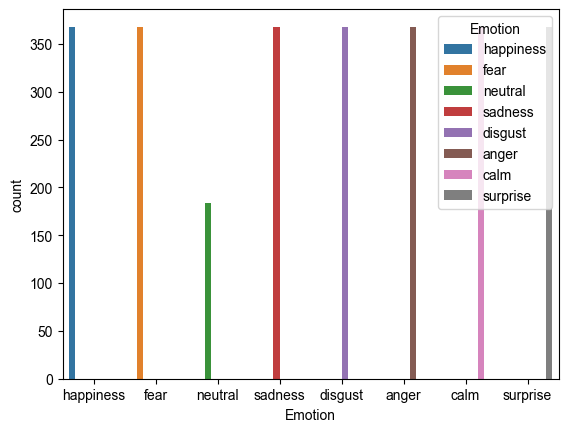

In [11]:
# Voyons la répartition de chaque émotion
sns.countplot(df, x="Emotion", hue="Emotion")
sns.set(rc={'figure.figsize':(16,5)})

In [12]:
df["anger"] = df['Emotion'].apply(is_anger)

In [13]:
# Dataframe de chaque categories de features

mfccs_list_columns = [f'mfccs_{i}' for i in range(len(mfccs_list[0]))]
df_mfccs = pd.DataFrame(mfccs_list, columns=mfccs_list_columns)

chroma_list_columns = [f'chroma_{i}' for i in range(len(chroma_list[0]))]
df_chroma = pd.DataFrame(chroma_list, columns=chroma_list_columns)

spectral_contrast_list_columns = [f'spectral_contrast_{i}' for i in range(len(spectral_contrast_list[0]))]
df_spectral_contrast = pd.DataFrame(spectral_contrast_list, columns=spectral_contrast_list_columns)

In [14]:
# Dataset d'exploitation avec features et sans features selection
features = pd.concat([df["Audio_File"],df_mfccs, df_chroma,df_spectral_contrast,df["anger"]], axis=1)
features = features.sample(frac = 1) # A changer si le dataset est trop grand
features.head()

,Audio_File,mfccs_0,mfccs_1,mfccs_2,mfccs_3,mfccs_4,mfccs_5,mfccs_6,mfccs_7,mfccs_8,...,spectral_contrast_691,spectral_contrast_692,spectral_contrast_693,spectral_contrast_694,spectral_contrast_695,spectral_contrast_696,spectral_contrast_697,spectral_contrast_698,spectral_contrast_699,anger
618,dis_N_dogs_rep1_F14.wav,-378.230957,-147.828445,-61.270527,-11.818419,10.102351,-2.181944,-23.292358,-40.734718,-47.687645,...,43.201608,42.778948,44.857264,44.657765,46.132781,48.539726,48.419984,46.837344,46.341023,0
408,fea_N_kids_rep1_F20.wav,-398.884430,-317.684967,-333.762970,-375.949219,-337.202789,-320.313873,-297.595123,-303.802612,-317.149872,...,44.568747,43.363276,42.867321,45.056064,46.448084,46.789549,44.238466,43.107447,48.340048,0
717,augmented_ang_N_kids_rep1_F10.wav,-511.473572,-492.631897,-490.067810,-485.700378,-487.335266,-477.557098,-471.596466,-484.152252,-489.793976,...,45.605876,50.850619,52.314062,47.887207,49.232260,48.161006,50.256966,51.346024,50.325773,1
1038,sad_N_kids_rep2_F2.wav,-544.362183,-299.286621,-218.807053,-212.497589,-216.737854,-213.081299,-210.852509,-204.946198,-199.189850,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1373,augmented_ang_N_dogs_rep1_F14.wav,-576.169800,-521.945984,-494.051178,-471.525757,-455.704926,-445.737030,-440.212555,-437.011017,-442.875122,...,13.431019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


In [15]:
features.shape

(2760, 3202)

In [16]:
# Sauverage du dataset en parquet
features.to_parquet('data/datasets/features.parquet', index=False)

## Entrainement des models

### Définition des modèles

In [17]:
# utilisation de l'algorithme des k plus proches voisins (KNN)
def train_model_knn(X_train, y_train):
    model = KNeighborsClassifier()
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_knn = grid_search.best_estimator_

    return best_knn

# utilisation de l'algorithme de Support Vector Classifier (SVC)
def train_model_svc(X_train, y_train):
    model = SVC()
    model.fit(X_train, y_train)

    return model

def train_model_dt(X_train, y_train):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)

    return model

In [18]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

### Séparation des données en données de train, test et validation

In [19]:
X = features.drop(columns=['Audio_File', 'anger'])
y = features["anger"].values

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [20]:
X_train_valid.shape, X_test.shape

((2208, 3200), (552, 3200))

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=21)

In [22]:
X_train.shape, X_valid.shape

((1987, 3200), (221, 3200))

### Entrainement des modèles

In [23]:
knn_model = train_model_knn(X_train, y_train)
evaluate_model(knn_model, X_test, y_test)

Accuracy: 0.9004
Precision: 0.8857
Recall: 0.9004


In [24]:
svm_model = train_model_svc(X_train, y_train)
evaluate_model(svm_model, X_test, y_test)

Accuracy: 0.8822
Precision: 0.7784
Recall: 0.8822


/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
dtc_model = train_model_dt(X_train, y_train)
evaluate_model(dtc_model, X_test, y_test)

Accuracy: 0.8315
Precision: 0.8304
Recall: 0.8315


In [26]:
# Sauvegarde des modeles
print("🔄 Models saving ...")
joblib.dump(knn_model, 'models/knn_model.pkl')
joblib.dump(svm_model, 'models/svm_model.pkl')
joblib.dump(dtc_model, 'models/dtc_model.pkl')
print("✅ Models saved successfully !")

🔄 Models saving ...
✅ Models saved successfully !


## Validation des modèles

Avant amélioration du KNN

In [27]:
predictions = knn_model.predict(X_valid)

In [28]:
y_valid

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0])

In [29]:
compare = pd.DataFrame({'Actual': y_valid, 'Predicted': predictions, 'OK ?': y_valid == predictions})
compare.head(20)

,Actual,Predicted,OK ?
0,0,0,True
1,1,0,False
2,0,0,True
3,0,0,True
4,0,0,True
5,1,1,True
6,0,0,True
7,0,0,True
8,0,0,True
9,0,0,True


In [30]:
# lignes dont la prédiction n'est pas correcte
compare[compare["OK ?"] == False]

,Actual,Predicted,OK ?
1,1,0,False
29,0,1,False
31,0,1,False
43,1,0,False
54,0,1,False
62,0,1,False
80,1,0,False
84,1,0,False
87,1,0,False
98,1,0,False


In [31]:
# nombre de lignes dont la prédiction n'est pas correcte
nombre_de_lignes = compare[compare["OK ?"] == False].shape[0]
print("Nombre de lignes dont la prédiction n'est pas correcte:", nombre_de_lignes)

Nombre de lignes dont la prédiction n'est pas correcte: 30


True     191
False     30
Name: OK ?, dtype: int64


<BarContainer object of 2 artists>

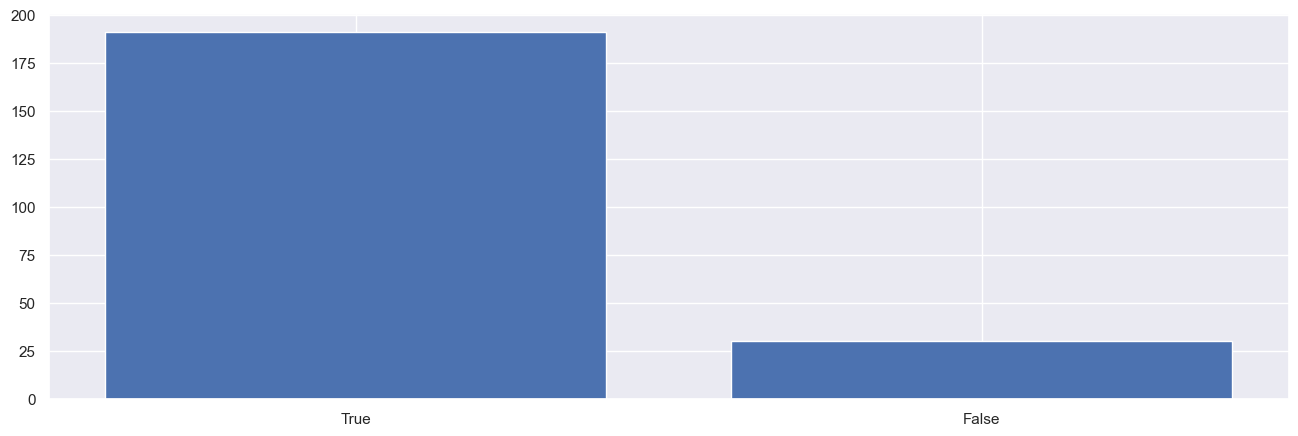

In [39]:
import matplotlib.pyplot as plt 

# Compter les occurrences de chaque valeur dans la colonne
counts = compare['OK ?'].value_counts()
print(counts)
# Créer le graphique à barres
plt.bar(["True", "False"], counts.values)

Après amélioration du knn

In [40]:
# utilisation de l'algorithme des k plus proches voisins (KNN)
from sklearn.ensemble import VotingClassifier
def train_model_knn_with_amelioration(X_train, y_train):
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9], 'metric': ['euclidean', 'manhattan']}
    knn = KNeighborsClassifier(weights='distance')
    grid_search = GridSearchCV(knn, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_k = best_params['n_neighbors']
    best_metric = best_params['metric']

    knn_clf = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
    knn_clf.fit(X_train, y_train)

    return knn_clf

In [41]:
knn_model_with_amelioration = train_model_knn_with_amelioration(X_train, y_train)

In [42]:
# Sauvegarde du knn amelioré
print("🔄 Models saving ...")
joblib.dump(knn_model_with_amelioration, 'models/knn_model_with_amelioration.pkl')

🔄 Models saving ...


['models/knn_model_with_amelioration.pkl']

In [43]:
predictions_with_amelioration = knn_model_with_amelioration.predict(X_valid)

In [44]:
compare = pd.DataFrame({'Actual': y_valid, 'Predicted': predictions_with_amelioration, 'OK ?': y_valid == predictions_with_amelioration})
compare.head(20)

,Actual,Predicted,OK ?
0,0,0,True
1,1,0,False
2,0,0,True
3,0,0,True
4,0,0,True
5,1,1,True
6,0,0,True
7,0,0,True
8,0,0,True
9,0,0,True


In [45]:
# lignes dont la prédiction n'est pas correcte
compare[compare["OK ?"] == False]

,Actual,Predicted,OK ?
1,1,0,False
28,1,0,False
43,1,0,False
62,0,1,False
84,1,0,False
85,0,1,False
87,1,0,False
98,1,0,False
101,1,0,False
117,1,0,False


In [46]:
# nombre total de predictions effectuées
print("nombre total de predictions:", predictions_with_amelioration.shape[0])

nombre total de predictions: 221


In [47]:
# nombre de lignes dont la prédiction n'est pas correcte
nombre_de_lignes = compare[compare["OK ?"] == False].shape[0]
print("Nombre de lignes dont la prédiction n'est pas correcte:", nombre_de_lignes)

Nombre de lignes dont la prédiction n'est pas correcte: 27


In [48]:
# avant amélioration du knn
evaluate_model(knn_model, X_test, y_test)

Accuracy: 0.9004
Precision: 0.8857
Recall: 0.9004


In [49]:
# après amélioration du modele KNN
evaluate_model(knn_model_with_amelioration, X_test, y_test)

Accuracy: 0.9203
Precision: 0.9129
Recall: 0.9203


True     194
False     27
Name: OK ?, dtype: int64


<BarContainer object of 2 artists>

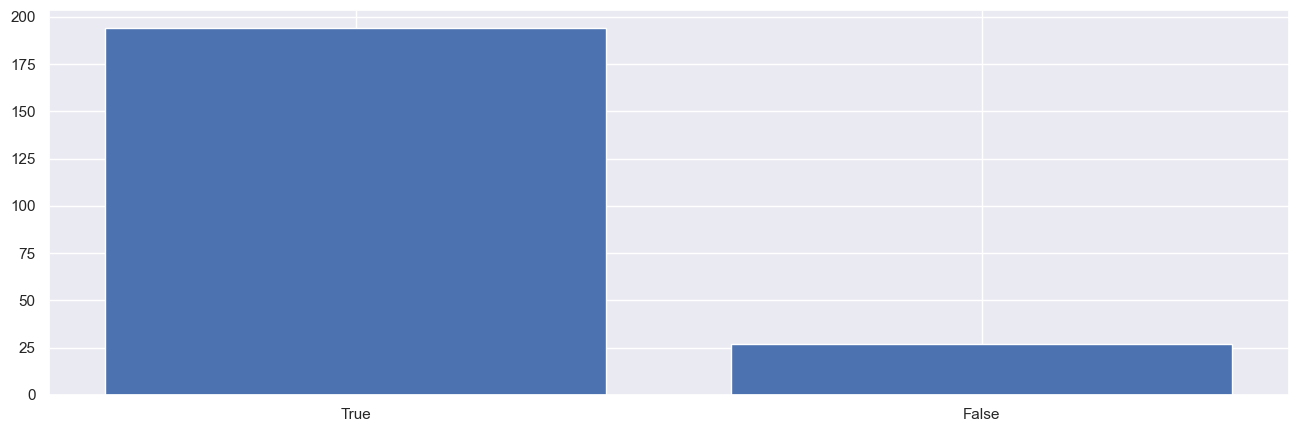

In [50]:
import matplotlib.pyplot as plt 

# Compter les occurrences de chaque valeur dans la colonne
counts = compare['OK ?'].value_counts()
print(counts)
# Créer le graphique à barres
plt.bar(["True", "False"], counts.values)

## Test des modèles sur d'autres fichiers audios

In [30]:
# Chargement des modeles
knn_model = joblib.load('models/knn_model.pkl')
svm_model = joblib.load('models/svm_model.pkl')
dtc_model = joblib.load('models/dtc_model.pkl')

In [31]:
def predict_emotion(audio_test_file):
    normalized_y, sr = process_audio(audio_test_file)
    flat_mfccs, flat_chroma, flat_spectral_contrast = extract_features(normalized_y, sr)

    flat_mfccs = np.array(flat_mfccs).reshape(1, -1)
    flat_chroma = np.array(flat_chroma).reshape(1, -1)
    flat_spectral_contrast = np.array(flat_spectral_contrast).reshape(1, -1)

    flat_features = np.concatenate((flat_mfccs, flat_chroma, flat_spectral_contrast), axis=1)

    knn_prediction = knn_model.predict(flat_features)
    svm_prediction = svm_model.predict(flat_features)
    dtc_prediction = dtc_model.predict(flat_features)

    print("Audio File is anger: ", audio_test_file)
    print("KNN: ", knn_prediction == 1)
    print("SVM: ", svm_prediction == 1)
    print("DTC: ", dtc_prediction == 1)

In [32]:
audio_file = "data/test_data/OAF_base_angry.wav"
predict_emotion(audio_file)

Audio File is anger:  data/test_data/OAF_base_angry.wav
KNN:  [ True]
SVM:  [False]
DTC:  [False]


/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [33]:
audio_file = "data/test_data/OAF_bath_angry.wav"
predict_emotion(audio_file)

Audio File is anger:  data/test_data/OAF_bath_angry.wav
KNN:  [ True]
SVM:  [False]
DTC:  [False]


/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [34]:
audio_file = "data/test_data/OAF_bean_angry.wav"
predict_emotion(audio_file)

Audio File is anger:  data/test_data/OAF_bean_angry.wav
KNN:  [ True]
SVM:  [False]
DTC:  [ True]


/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [35]:
audio_file = "data/test_data/OAF_beg_angry.wav"
predict_emotion(audio_file)

Audio File is anger:  data/test_data/OAF_beg_angry.wav
KNN:  [ True]
SVM:  [False]
DTC:  [ True]


/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [36]:
audio_file = "data/test_data/OAF_book_angry.wav"
predict_emotion(audio_file)

Audio File is anger:  data/test_data/OAF_book_angry.wav
KNN:  [ True]
SVM:  [False]
DTC:  [ True]


/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


## Test du knn amelioré sur d'autres fichiers audio

In [131]:
# chargement du modele
knn_model_with_amelioration = joblib.load('models/knn_model_with_amelioration.pkl')

In [140]:

def predict_angry(knn_model, audio_test_file):
    
    normalized_y, sr = process_audio(audio_test_file)
    flat_mfccs, flat_chroma, flat_spectral_contrast = extract_features(normalized_y, sr)

    flat_mfccs = np.array(flat_mfccs).reshape(1, -1)
    flat_chroma = np.array(flat_chroma).reshape(1, -1)
    flat_spectral_contrast = np.array(flat_spectral_contrast).reshape(1, -1)

    flat_features = np.concatenate((flat_mfccs, flat_chroma, flat_spectral_contrast), axis=1)

    knn_prediction = knn_model.predict(flat_features)

    return audio_test_file, knn_prediction == 1

In [155]:
audio_directory_for_test = "data/test_data"
lst_result = []
for filename in os.listdir(audio_directory_for_test):
    file_path = os.path.join(audio_directory_for_test, filename)
    lst_result.append(predict_angry(knn_model_with_amelioration, file_path))
    
df = pd.DataFrame(columns= ["Filename", "Is_angry"])
for element in lst_result:
    df = df.append({'Filename': element[0], 'Is_angry': element[1][0]}, ignore_index=True)

/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/frederique/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with featur

In [163]:
df

,Filename,Is_angry
0,data/test_data/OAF_calm_angry.wav,True
1,data/test_data/OAF_chalk_angry.wav,False
2,data/test_data/OAF_book_angry.wav,True
3,data/test_data/OAF_beg_angry.wav,True
4,data/test_data/OAF_bath_angry.wav,True
5,data/test_data/OAF_cause_angry.wav,False
6,data/test_data/OAF_burn_angry.wav,True
7,data/test_data/OAF_came_angry.wav,True
8,data/test_data/OAF_chat_angry.wav,True
9,data/test_data/OAF_chair_angry.wav,True


In [164]:
average_true = (df[df["Is_angry"] == True].shape[0] / df.shape[0]) * 100
average_true

83.33333333333334